# Covid19 Lung X-Ray Classification
### Anish Indukur

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping

# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")

In [6]:
trainLabels = pd.read_csv('trainLabels.csv')
testLabels = pd.read_csv('testLabels.csv')

trainImages = np.load('trainimage.npy')
testImages = np.load('testimage.npy')

trainImages.shape

(251, 128, 128, 3)

In [62]:
trainLabels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   251 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB


251 Images in train set, with 3 channels and 128X128 res

## Exploratory data Analysis

Training Data


<function matplotlib.pyplot.show(close=None, block=None)>

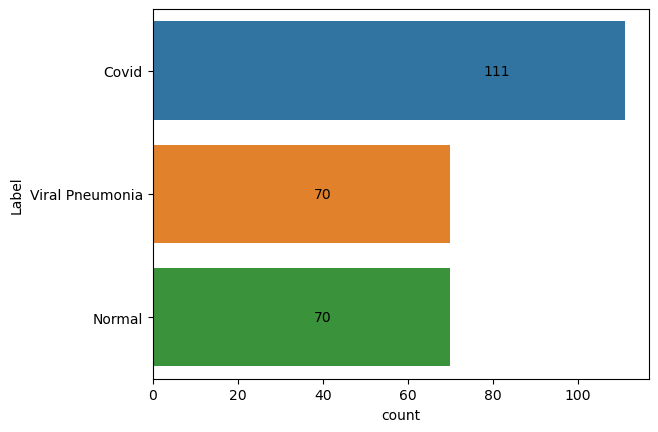

In [50]:
# Countplot showing number of data points for each category
print("Training Data")
sns.countplot(data=trainLabels, y='Label', order=trainLabels['Label'].value_counts().index)
for i, count in enumerate(trainLabels['Label'].value_counts()):
    plt.annotate(count, (count - 30, i), ha='center', va='center')



test Data


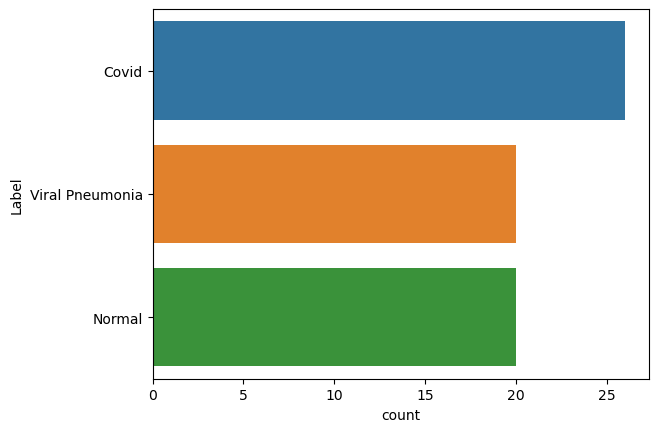

In [52]:
print('\n')
print("Test Data")
sns.countplot(data=testLabels, y='Label', order=testLabels['Label'].value_counts().index)
for i, count in enumerate(testLabels['Label'].value_counts()):
    plt.annotate(count, (count - 30, i), ha='center', va='center')

In the dataset there are a few more covid images than viral pneumonia and normal. The difference is not too large, so it should not cause an issue. 

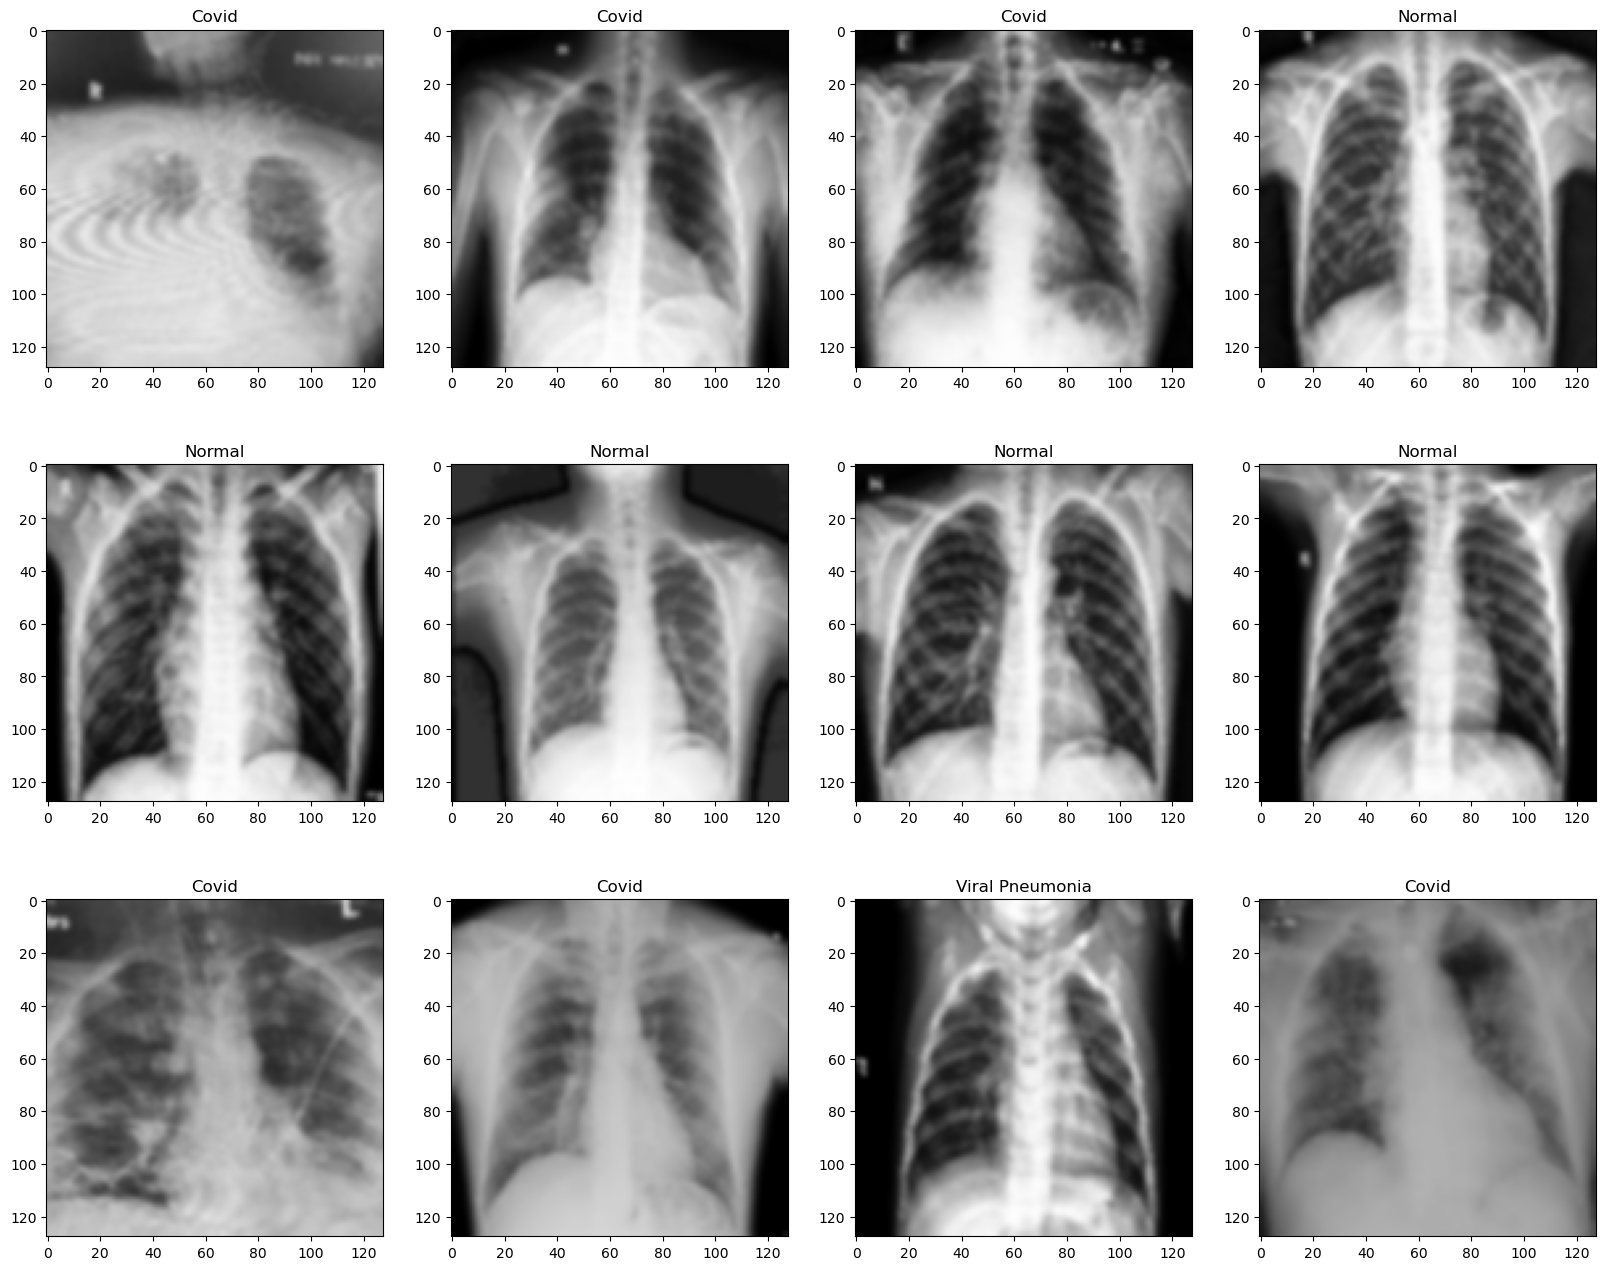

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Verify that trainLabels and trainImages are correctly defined
assert len(trainLabels) == len(trainImages), "Mismatch between trainLabels and trainImages lengths"

num_classes = 3  # Number of Classes
categories = np.unique(trainLabels['Label'])  # Obtaining the unique classes from the 'Label' column

rows = 3  # Defining number of rows=3
cols = 4  # Defining number of columns=4

fig = plt.figure(figsize=(20, 16))  # Defining the figure size to 20x16

# Create a list of unique indices to ensure that each image is displayed once
unique_indices = list(range(len(trainLabels)))
np.random.shuffle(unique_indices)  # Shuffle the indices randomly

for i in range(cols):
    for j in range(rows):
        if unique_indices:
            random_index = unique_indices.pop()  # Get the next unique index
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)  # Adding subplots with 3 rows and 4 columns
            image = trainImages[random_index]
            
            # Access the label from the DataFrame and convert it to a string
            label = str(trainLabels.loc[random_index, 'Label'])
            
            ax.imshow(image, cmap=plt.get_cmap('gray'))  # Plotting the image using cmap=gray
            ax.set_title(label)
        else:
            print("No more unique indices.")

plt.show()


From taking a quick look at the data we can see that the scans have a lot of variability between them. Even scans from the same class seem to look different in some cases. This may require a larger neural network for the project to work effectively. 

## Data Prep

In [7]:
# Applying Gaussian Blurring
for i in range(trainImages.shape[0]):
    image = trainImages[i]
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    trainImages[i] = blurred_image
    
for i in range(testImages.shape[0]):
    image = testImages[i]
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    testImages[i] = blurred_image

In [8]:
# Normalizing the images
X_train_normalized = trainImages.astype('float32')/255.0
X_test_normalized = testImages.astype('float32')/255.0

In [9]:
# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(trainLabels)
y_test_encoded = label_encoder.transform(testLabels)

# Convert encoded labels to one-hot representation
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

In [10]:
# Getting the labels associated with the encoded values
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Print the mapping
for encoded_label, original_label in label_mapping.items():
    print(f"Encoded Label: {encoded_label} --> Original Label: {original_label}")

Encoded Label: 0 --> Original Label: Covid
Encoded Label: 1 --> Original Label: Normal
Encoded Label: 2 --> Original Label: Viral Pneumonia


## Model Building

In [11]:
# Fixing the seed for random number generators
import random
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

Starting Small with the first Model:
   * Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel
* Max Pooling
* Last conv layer
* Last max pooling
* Flatten
* Dense hidden layer, 8 neurons, relu activation
* Output layer, 3 neurons, softmax activation

In [12]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Flatten())
  
model.add(Dense(8, activation='relu'))

model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.01)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 8)         0

In [13]:
es = EarlyStopping(monitor = 'val_loss', patience=10)

history_1 = model.fit(
    X_train_normalized, y_train_encoded,
    epochs=30,
    validation_split=0.1,
    shuffle=True,
    batch_size=64,
    verbose=2,
    callbacks = [es]
)

Epoch 1/30
4/4 - 0s - loss: 1.1408 - accuracy: 0.3333 - val_loss: 2.2625 - val_accuracy: 0.0000e+00 - 498ms/epoch - 125ms/step
Epoch 2/30
4/4 - 0s - loss: 1.0153 - accuracy: 0.4933 - val_loss: 1.2455 - val_accuracy: 0.0000e+00 - 236ms/epoch - 59ms/step
Epoch 3/30
4/4 - 0s - loss: 0.8671 - accuracy: 0.4933 - val_loss: 1.2401 - val_accuracy: 0.0000e+00 - 234ms/epoch - 59ms/step
Epoch 4/30
4/4 - 0s - loss: 0.7038 - accuracy: 0.4933 - val_loss: 1.2493 - val_accuracy: 0.0000e+00 - 239ms/epoch - 60ms/step
Epoch 5/30
4/4 - 0s - loss: 0.7014 - accuracy: 0.4933 - val_loss: 1.7370 - val_accuracy: 0.0000e+00 - 240ms/epoch - 60ms/step
Epoch 6/30
4/4 - 0s - loss: 0.6285 - accuracy: 0.5333 - val_loss: 1.3289 - val_accuracy: 0.9231 - 284ms/epoch - 71ms/step
Epoch 7/30
4/4 - 0s - loss: 0.6081 - accuracy: 0.6267 - val_loss: 1.9161 - val_accuracy: 0.0000e+00 - 261ms/epoch - 65ms/step
Epoch 8/30
4/4 - 0s - loss: 0.5834 - accuracy: 0.7689 - val_loss: 1.7122 - val_accuracy: 0.0000e+00 - 241ms/epoch - 60ms/

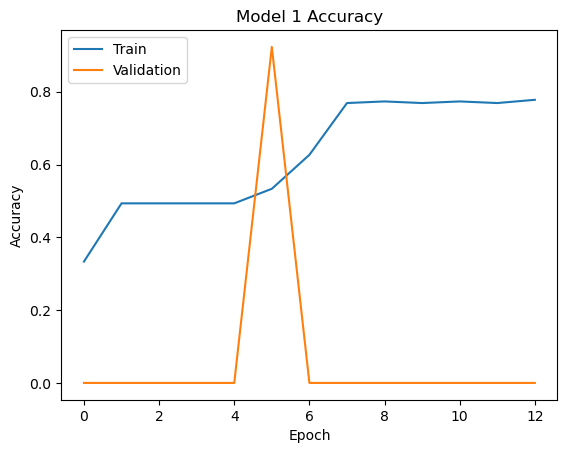

In [14]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [16]:
model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

3/3 - 0s - loss: 0.8569 - accuracy: 0.6061 - 80ms/epoch - 27ms/step


[0.8568716049194336, 0.6060606241226196]

In [17]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model.predict(X_test_normalized)

3/3 [==============================] - 0s 7ms/step


In [18]:
# Creating dataframe to store metrics for all models
data = {'Model_1': [0,0,0],
        'Model_2': [0,0,0],
        'Model_3': [0,0,0],
        'Model_4': [0,0,0]}
  
comparisonTable = pd.DataFrame(data, index=['Accuracy:',
                               'Precision:',
                               'Recall:'])

Accuracy: 0.6060606060606061
Precision: 0.49098124098124096
Recall: 0.6060606060606061


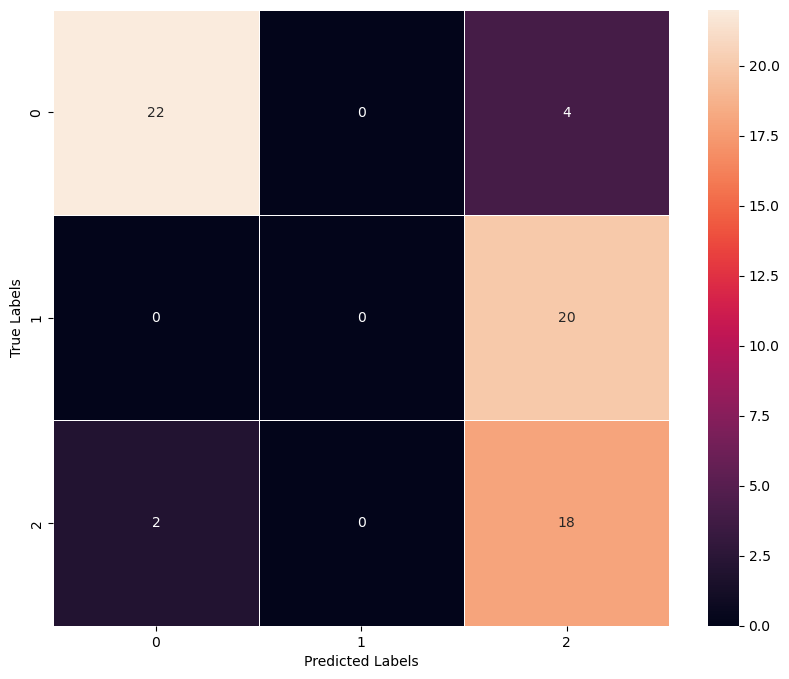

In [19]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_1'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_1'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_1'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Add labels for X and Y axis
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

* Looks like the model is not generating many false positives for COVID scans (0).
* The model is mistaking quite a few normal scans for pneumonia

Model may be underfitting, for next model we can add more neurons to each layer to increase complexity

In [20]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

Adding more complexity to second model to reduce underfitting:
* Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel
* Max Pooling
* Last conv layer
* Last max pooling
* Flatten
* Dense hidden layer, 16 neurons
* Output layer, 3 neurons


In [21]:
model_1 = Sequential()

model_1.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Flatten())
  
model_1.add(Dense(16, activation='relu'))

model_1.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.01)

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 8)         0

In [22]:
#Running the model
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=40,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2,
            callbacks = [es]
)

Epoch 1/40
4/4 - 0s - loss: 1.6179 - accuracy: 0.4178 - val_loss: 1.1380 - val_accuracy: 0.0000e+00 - 461ms/epoch - 115ms/step
Epoch 2/40
4/4 - 0s - loss: 1.0778 - accuracy: 0.4933 - val_loss: 1.3974 - val_accuracy: 0.0000e+00 - 281ms/epoch - 70ms/step
Epoch 3/40
4/4 - 0s - loss: 0.9353 - accuracy: 0.6222 - val_loss: 1.9469 - val_accuracy: 0.0000e+00 - 288ms/epoch - 72ms/step
Epoch 4/40
4/4 - 0s - loss: 0.6875 - accuracy: 0.7822 - val_loss: 0.4876 - val_accuracy: 0.8846 - 287ms/epoch - 72ms/step
Epoch 5/40
4/4 - 0s - loss: 0.4155 - accuracy: 0.8400 - val_loss: 0.9216 - val_accuracy: 0.6923 - 280ms/epoch - 70ms/step
Epoch 6/40
4/4 - 0s - loss: 0.3600 - accuracy: 0.8667 - val_loss: 1.8104 - val_accuracy: 0.4615 - 273ms/epoch - 68ms/step
Epoch 7/40
4/4 - 0s - loss: 0.3103 - accuracy: 0.8889 - val_loss: 0.4547 - val_accuracy: 0.8077 - 275ms/epoch - 69ms/step
Epoch 8/40
4/4 - 0s - loss: 0.2448 - accuracy: 0.9111 - val_loss: 1.0805 - val_accuracy: 0.6154 - 272ms/epoch - 68ms/step
Epoch 9/40


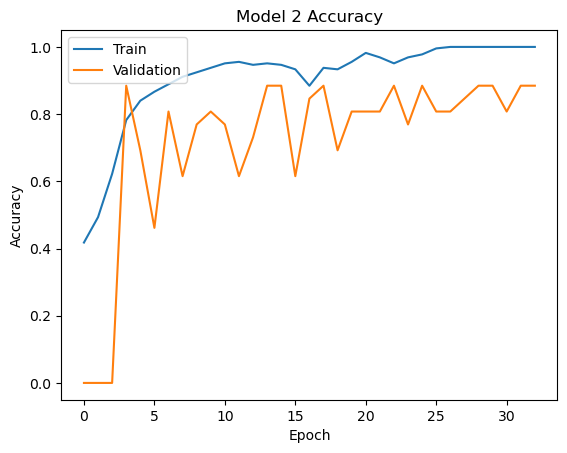

In [23]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

3/3 - 0s - loss: 0.8192 - accuracy: 0.8788 - 37ms/epoch - 12ms/step


[0.8192270398139954, 0.8787878751754761]

In [25]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model_1.predict(X_test_normalized)

3/3 [==============================] - 0s 8ms/step


Accuracy: 0.8787878787878788
Precision: 0.8859955049213362
Recall: 0.8787878787878788


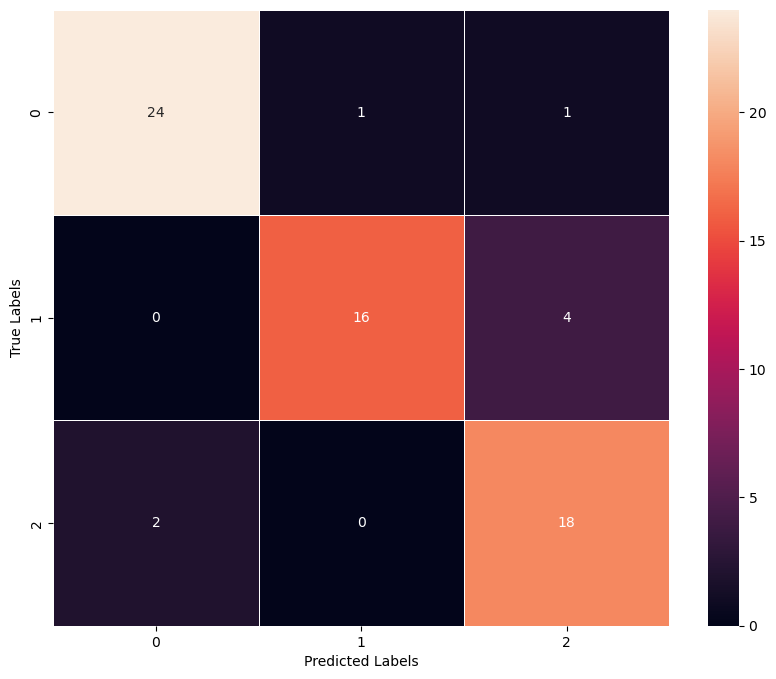

In [26]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_2'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_2'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_2'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Add labels for X and Y axis
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

This model is working much better than the previous one 
* Accuracy has gove up by a lrage amount to 0.89
* Model is misclassifying 4 of the pneumonia pictures as normal.
* Once again the model is doing a good job of classifying COVID scans
* If we only care to classify covid scans, this model will work great

In [27]:
backend.clear_session()

For the last model we can add more complexity to see if the performance increases
* Adding more neurons to Conv layers
* Adding one more dense layer with 16 neurons

In [28]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(18, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Flatten())
  
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

model_2.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.01)

# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 18)        2610      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 18)        0

In [29]:
# Running the model for 20 epochs
es = EarlyStopping(monitor = 'val_loss', patience=10)

history_3 = model_2.fit(
            X_train_normalized, y_train_encoded,
            epochs=20,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2,
            callbacks = [es]
)

Epoch 1/20
4/4 - 1s - loss: 1.1527 - accuracy: 0.4578 - val_loss: 1.3150 - val_accuracy: 0.0000e+00 - 630ms/epoch - 157ms/step
Epoch 2/20
4/4 - 0s - loss: 1.0198 - accuracy: 0.4711 - val_loss: 1.1647 - val_accuracy: 0.0000e+00 - 398ms/epoch - 100ms/step
Epoch 3/20
4/4 - 0s - loss: 0.8856 - accuracy: 0.6622 - val_loss: 1.8844 - val_accuracy: 0.0000e+00 - 398ms/epoch - 99ms/step
Epoch 4/20
4/4 - 0s - loss: 0.6858 - accuracy: 0.7289 - val_loss: 1.3990 - val_accuracy: 0.0385 - 406ms/epoch - 101ms/step
Epoch 5/20
4/4 - 0s - loss: 0.6160 - accuracy: 0.7600 - val_loss: 1.2158 - val_accuracy: 0.2308 - 390ms/epoch - 98ms/step
Epoch 6/20
4/4 - 0s - loss: 0.5633 - accuracy: 0.7956 - val_loss: 1.6438 - val_accuracy: 0.1154 - 380ms/epoch - 95ms/step
Epoch 7/20
4/4 - 0s - loss: 0.4527 - accuracy: 0.8222 - val_loss: 0.6197 - val_accuracy: 0.7692 - 381ms/epoch - 95ms/step
Epoch 8/20
4/4 - 0s - loss: 0.4011 - accuracy: 0.8444 - val_loss: 1.1569 - val_accuracy: 0.5769 - 381ms/epoch - 95ms/step
Epoch 9/2

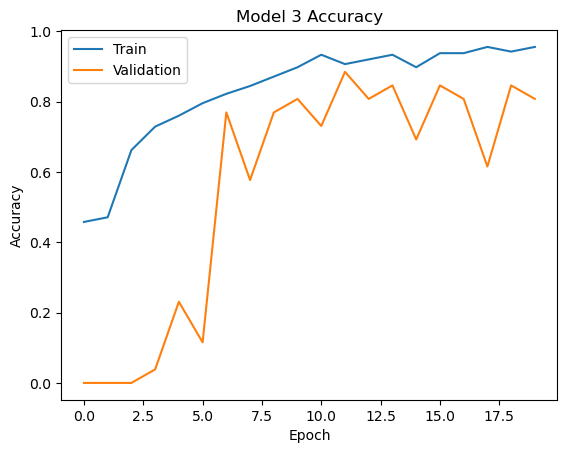

In [30]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

3/3 - 0s - loss: 0.4413 - accuracy: 0.8485 - 45ms/epoch - 15ms/step


[0.44127157330513, 0.8484848737716675]

In [32]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model_2.predict(X_test_normalized)

3/3 [==============================] - 0s 11ms/step


Accuracy: 0.8484848484848485
Precision: 0.8481641814975147
Recall: 0.8484848484848485


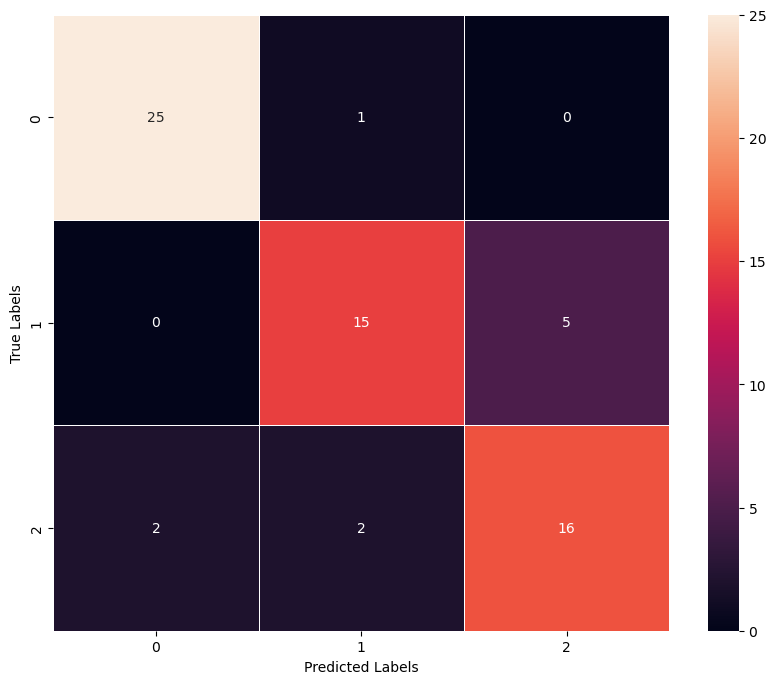

In [33]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_3'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_3'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_3'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Add labels for X and Y axis
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

This model is performing worse than the previous, less complex one. This is indicative of overfitting. 
* the accuracy and precision have both dropped compared to the previous model 
* This model seems to be making similar mistakes as the previous, but making them more frequently

## Conclusion

In conclusion, the second Model_2 is the best one to use for this project. 

In [35]:
print("Validation Metrics")
display(comparisonTable)

Validation Metrics


,Model_1,Model_2,Model_3,Model_4
Accuracy:,0.606061,0.878788,0.848485,0
Precision:,0.490981,0.885996,0.848164,0
Recall:,0.606061,0.878788,0.848485,0


* Model_1 was the first guess for model size and architecture. It was very clearly underfitting, with the validation accuracy very far below the training accuracy.
* Model_2 was the second guess, with a moderate increase in model size, no new added layers. This model performed the best, with accuracy, precision, and recall all reaching the high 80s.
* Model_3 was the final try to improve on Model_2's performance, this model added a leyer and made the layers larger as well. This model fell victim with overfitting, the training accuracy reached 1.00 quickly, and validation accuracy never went above 0.84.

In a future approach, transfer learning may be a plausible strategy. Using a pre-trained model may allow for a more specialized model overall. 